# AM216 Final-Project: Extend Mini-Project: Predicting drug target interaction using 3D information and predicting ligands that can bind to COVID-19 targets.

Components of X:
*   **Protein**: residues chains (vector length 1000 or other lengths we choose to truncate)
*   **Protein 3D**: contact map of residue distances (vector length around ~20000 after flattening the triangular matrix; need to standardize)
*   **Ligand**: ECFP signature (1024 or 2048)

y: affinity score

Proposed models:
1.   **Mini project**: concatenate protein residue chain and ligant signature to get X
2.   **Just contact map**: concatenate flattened contact map and ligand signature to get X
3.   **Early fusion**: concatenate protein residue chain, flattened contact map and ligand signature to get X
4.   **Late fusion**: train and predict using Model 1 and Model 2 separately, consensus model at the end
5.   **CNN**: Instead of flattening contact map, use convolutaional NN to convolve the map and derive flattened layer
6.   **Pocket**: Instead of using the contact map of the whole protein, get the residues of the just the pocket and get the contact map










## 1. Install Packages

*   Rdkit
*   Deepchem
* Lifelines (calculate CI scores faster)
* Biopython (BioPython's **Bio.PDB** module includes code to load PDB files and calculate the alpha carbon distance between pair of their residues)





In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
%%capture cap --no-stderr 
#%%capture is used to suppress the output of this particular cell 
from sklearn import preprocessing
from sklearn import utils
import sys
import time
import os.path
if not os.path.exists('Anaconda3-2019.10-Linux-x86_64.sh'):
  t_start = time.time()
  !wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
  !chmod +x Anaconda3-2019.10-Linux-x86_64.sh
  !bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local
  print("Done: Anaconda3", file=sys.stderr)
  t_end = time.time(); print("----Elasped: %f seconds" % (t_end - t_start), file=sys.stderr); t_start = time.time();


  !conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
  
  print("Done: deepchem & rdkit", file=sys.stderr)
  # !conda create -c conda-forge -n my-rdkit-env rdkit;
  # !activate my-rdkit-env; #(OR TRY: !activate my-rdkit-env)
  # !conda install -c conda-forge rdkit;
  # print("Done: rdkit", file=sys.stderr)
  t_end = time.time(); print("----Elasped: %f seconds" % (t_end - t_start), file=sys.stderr); t_start = time.time();

  !pip install lifelines;
  !pip install biopython;
  !pip install mmtf-python;
  print("Done: pip install lifelines & biopython & mmtf-python", file=sys.stderr)
  t_end = time.time(); print("----Elasped: %f seconds" % (t_end - t_start), file=sys.stderr);

Done: Anaconda3
----Elasped: 86.172290 seconds
Done: deepchem & rdkit
----Elasped: 259.604990 seconds
Done: pip install lifelines & biopython & mmtf-python
----Elasped: 9.091208 seconds


In [3]:
%%capture
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import warnings
warnings.filterwarnings("ignore")

import deepchem as dc
import numpy as np
import os.path
import urllib.request
import pandas as pd
import Bio.PDB
import tensorflow as tf


from rdkit.Chem import AllChem as Chem
from rdkit.Chem import MolFromSmiles
from Bio.PDB.mmtf import MMTFParser

  
import matplotlib.pyplot as plt
import json
import pickle
import networkx as nx
from collections import OrderedDict
from lifelines.utils import concordance_index as ci
from sklearn.model_selection import train_test_split


## 2. Parsing Data
TODO: describe the data we are using.

### 2.1 Parsing PDB data to get the 3D info


In [4]:
def subsample(dataFrame, n_or_frac):
  if n_or_frac < 1.0:
    return dataFrame.sample(frac = n_or_frac)
  else:
    return dataFrame.sample(n = n_or_frac)

with open('Ligand_Dict.json') as f:
    ligand_dict = json.load(f)
pdb_data = pd.read_csv('PDBbind2019PLdata_cleaned.csv')


pdb_proteinName = np.array(pdb_data['proteinName'])
pdb_affinity = np.array(pdb_data['affinity'])
pdb_ligandName = np.array(pdb_data['ligandName'])


# pdb_data_small = pd.read_csv('pdbbind_core_df_cleaned.csv')
# pdb_proteinName_small = np.array(pdb_data_small['proteinName'])
# pdb_affinity_small = np.array(pdb_data_small['affinity'])
# pdb_ligandName_small = np.array(pdb_data_small['ligandName'])


# SAMPLE_SIZE = 30
# pdb_data_medium = subsample(pdb_data, SAMPLE_SIZE)
# pdb_proteinName_medium = np.array(pdb_data_medium['proteinName'])
# pdb_affinity_medium = np.array(pdb_data_medium['affinity'])
# pdb_ligandName_medium = np.array(pdb_data_medium['ligandName'])

In [5]:
print("pdb_proteinName.shape:", pdb_proteinName.shape)
print("pdb_affinity.shape:", pdb_affinity.shape)
print("pdb_ligandName.shape:", pdb_ligandName.shape)

# print("\n\npdb_proteinName_small.shape:", pdb_proteinName_small.shape)
# print("pdb_affinity_small.shape:", pdb_affinity_small.shape)
# print("pdb_ligandName_small.shape:", pdb_ligandName_small.shape)

# print("\n\npdb_proteinName_medium.shape:", pdb_proteinName_medium.shape)
# print("pdb_affinity_medium.shape:", pdb_affinity_medium.shape)
# print("pdb_ligandName_medium.shape:", pdb_ligandName_medium.shape)

pdb_proteinName.shape: (15080,)
pdb_affinity.shape: (15080,)
pdb_ligandName.shape: (15080,)


 #### 3D Representation 1: Contact map

We get the list of residues in each protein and treat that as a single chain to calculate the contact map of this protein. After flattened, the length of the contact map vector should be **O(residue_count * residue_count)**, which is too big for some proteins with large number of residues. Hence, we tried to shrink it by collapsing the 3D coordinates a group of neighboring residues into a single one.

In [6]:
def filter_residues(residues):
  new_residues = []
  for res in residues:
    if 'CA' in res:
      new_residues.append(res)
  return new_residues

def calc_residue_dist_by_residues(residue_one, residue_two) :
    """Returns the C-alpha distance between two residues"""
    diff_vector  = residue_one["CA"].coord - residue_two["CA"].coord
    return np.sqrt(np.sum(diff_vector * diff_vector))

#Essentially the Euclidean distance between 2 coords
def calc_residue_dist_by_coords(coord1, coord2) :
    """Returns the C-alpha distance between two residues"""
    diff_vector  = coord1 - coord2
    # return np.sqrt(np.sum(diff_vector * diff_vector))
    return np.linalg.norm(diff_vector)



# We expect residue_list1 and residue_list2 to be the same thing: residue list of one protein. Hence the result should be a symmetric matrix, and thus we decided to only calculate the independent entries.
def calc_dist_matrix_by_residues(residue_list1) :
    """Returns a matrix of C-alpha distances between two chains"""
    # answer = np.zeros((len(residue_list1), len(chain_two)), np.float)
    answer = []
    for row, residue_one in enumerate(residue_list1) :
        for col, residue_two in enumerate(residue_list1[row+1:]) :
            answer.append(calc_residue_dist(residue_one, residue_two))
    return answer

def calc_dist_matrix_by_coords(coord_list1) :
    """Returns a matrix of C-alpha distances between two chains"""
    # answer = np.zeros((len(residue_list1), len(chain_two)), np.float)
    answer = []
    for row, coord1 in enumerate(coord_list1) :
        for col, coord2 in enumerate(coord_list1[row+1:]) :
            answer.append(calc_residue_dist_by_coords(coord1, coord2))
    return answer


# Returns the contact map for one protein and prints the info - slow (for demonstration purpose)
# It does the shrinking by shrinking_ratio within each chain (coords from end of chain1 and start of chain 2 will NOT be collapsed together).
def get_protein_contact_map_slow(proteinName, shrinking_ratio=20):
  structure=MMTFParser.get_structure_from_url(proteinName)
  all_chains =structure[0]
  
  #Get 1.residues: list of all residues in the protein
#      2.CA_coord_list has length equal num of chains. 
  residues = []
  CA_coord_list = []

  for idx_chain, chain in enumerate(all_chains):
    CA_curr_chain = []
    for idx_residue, residue in enumerate(chain):
      residues.append(residue)
      if 'CA' in residue:
        CA_curr_chain.append(residue['CA'].coord)
    CA_coord_list.append(CA_curr_chain)
    print("Chain with id %d has %d residues in total, and %d residues with CA." % (idx_chain, len(chain), len(CA_curr_chain)))
  print("\nCount of residues: ", len(residues))
  residues = filter_residues(residues)
  print("Count of residues with CA: ", len(residues))


  # Get coord_list: collapsing list of CA coords of all resiudues with CA in the protein
  coord_list = []
  for CA_curr_chain in CA_coord_list:
    cutting_points = list(np.arange(0,len(CA_curr_chain),shrinking_ratio))
    cutting_points.append(len(CA_curr_chain))
    for i, start in enumerate(cutting_points[:-1]):
      end = cutting_points[i+1]
      coord_list.append(np.mean(CA_curr_chain[start:end],axis=0))
  print("After shrinking, len(coord_list) = ", len(coord_list))


  # Calculate contact_map: pair wise distance of the coords
  contact_map = calc_dist_matrix_by_coords(coord_list)
  print("len(contact_map) = ", len(contact_map))
  return contact_map



# Returns the contact map for one protein and does not print the info - fast
# It does not do the exact shrinking within each chain (That is, coords from end of chain1 and start of chain 2 will be collapsed together).
def get_protein_contact_map(proteinName, shrinking_ratio=20):
  structure=MMTFParser.get_structure_from_url(proteinName)
  all_chains =structure[0]
  
  #Get CA_coord_list: list of CA coords of all residues with CA
  CA_coord_list = []
  for idx_chain, chain in enumerate(all_chains):
    for idx_residue, residue in enumerate(chain):
      if 'CA' in residue:
        CA_coord_list.append(residue['CA'].coord)
  # print("len(CA_coord_list) = ", len(CA_coord_list))

  # Get coord_list: collapsing list of CA coords of all resiudues with CA in the protein
  coord_list = []
  cutting_points = list(np.arange(0,len(CA_coord_list),shrinking_ratio))
  cutting_points.append(len(CA_coord_list))
  for i, start in enumerate(cutting_points[:-1]):
    end = cutting_points[i+1]
    coord_list.append(np.mean(CA_coord_list[start:end],axis=0))
  # print("After shrinking, len(coord_list) = ", len(coord_list))

  # Calculate contact_map: pair wise distance of the coords
  contact_map = calc_dist_matrix_by_coords(coord_list)
  # print("len(contact_map) = ", len(contact_map))

  return contact_map



#Cutting/Padding: use the code from miniproject (how they got 1000-long vector for proteins)
CONTACT_MAP_LENGTH=1000

def cut_or_pad(my_list, length):
    array = np.zeros(length)
    for i, row in enumerate(my_list[:length]): 
        array[i] = row
    return array 

def get_protein_cut_contact_map(proteinName, shrinking_ratio=20):
  contact_map_uncut = get_protein_contact_map(proteinName, shrinking_ratio)
  contact_map = cut_or_pad(contact_map_uncut, CONTACT_MAP_LENGTH)
  return contact_map


Below we are trying to find the fastest way to loop through all residues and get the CA coords from residues with CA.

Conclusion: for all the 5 approaches we tried, including using list comprehensiong and mapping, it still takes about 0.5 sec to calculate the CA coordinate list for 1 protein.

Now we continue processing the contact maps for all proteins. Then we need to do cutting/padding on the data (list of distinct-length lists) so they have equal length in the end (list of equal-length lists)

In [8]:
# Get contact maps for all proteins:
SHRINKING_RATIO = 20 #after exploring, 20 is a good SHRINKING_RATIO to shrink the contact maps into reasonable lengths
contact_maps = []
lens = []

for i in range(len(pdb_proteinName_medium)):
  cm = get_protein_contact_map(pdb_proteinName_medium[i], shrinking_ratio=SHRINKING_RATIO)
  contact_maps.append(cm)
  lens.append(len(cm))
  
  if i %10==0:
    print(i, end=",")
  
print("\nNum of contact maps: ", len(contact_maps))
print("Min length = ", np.min(lens))
print("Max length = ", np.max(lens))
plt.hist(lens, bins=100);
plt.title("Distribution of lengths of contact maps (before cutting/padding)");


NameError: ignored

In [ ]:
#Cutting/Padding: use the code from miniproject (how they got 1000-long vector for proteins)
CONTACT_MAP_LENGTH=1000


contact_maps = np.array([cut_or_pad(cm, CONTACT_MAP_LENGTH) for cm in contact_maps])
print("contact_maps.shape = ", contact_maps.shape)

contact_maps.shape =  (30, 1000)


Note: After optimizing the code as much as we can, getting the contact maps of proteins is still slow because of the unavoidable calculation to loop through the residues and get the coordinates of their CA (if exists). Each protein takes about **1 sec** to calculate its contact map. This situation is the same for the 2nd 3D representation: using distances from the center.

Hence, we will try to use the medium (sampled from the total 17680 data points) or small data set (from 'pdbbind_core_df_cleaned.csv', which only has 193 data points).

 #### 3D Representation 2: Center Distances (Distances of residues from the center.)
We assume a center for the protein, which is calculated by averaging the 3D coordinates of the residues. Then we use the distances of residues from this center as our 3D representation of this protein. One advantage of this representation is that the final length is of order **O(residue_count)**.


In [7]:
CENTER_DISTANCES_LENGTH = 1000
def get_protein_center_distances(proteinName, printInfo=False):
  all_chains=MMTFParser.get_structure_from_url(proteinName)[0]
  
  #Step1: Get CA_coord_list: list of CA coords of all residues with CA
  CA_coord_list = []
  for idx_chain, chain in enumerate(all_chains):
    for idx_residue, residue in enumerate(chain):
      if 'CA' in residue:
        CA_coord_list.append(residue['CA'].coord)
  if printInfo:
    print("len(CA_coord_list) = ", len(CA_coord_list))

  #Step2: average coords to get center
  center = np.mean(CA_coord_list, axis=0)
  if printInfo:
    print("center = ", center)


  #Step3: calculate distances from the center
  distances = []
  for coord in CA_coord_list:
    dist = calc_residue_dist_by_coords(center, coord)#Essentially the Euclidean distance between 2 coords
    distances.append(dist)
  if printInfo:
    print("len(distances) = ", len(distances))

  return distances



def get_protein_cut_center_distances(proteinName):
  distances_uncut = get_protein_center_distances(proteinName)
  distances = cut_or_pad(distances_uncut, CENTER_DISTANCES_LENGTH)
  return distances

0,10,20,
Num of contact maps:  30
Min length =  155
Max length =  4044


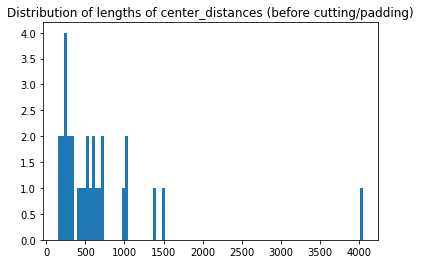

In [ ]:
# Get center_distances for all proteins:

center_distances = []
lens = []
for i in range(len(pdb_proteinName_medium)):
  d = get_protein_center_distances(pdb_proteinName_medium[i])
  center_distances.append(d)
  lens.append(len(d))
  
  if i %10==0:
    print(i, end=",")
  

print("\nNum of contact maps: ", len(center_distances))
print("Min length = ", np.min(lens))
print("Max length = ", np.max(lens))
plt.hist(lens, bins=100);
plt.title("Distribution of lengths of center_distances (before cutting/padding)");


In [ ]:
#Cutting/Padding: use the code from miniproject (how they got 1000-long vector for proteins)
CENTER_DISTANCE_LENGTH=1000

center_distances = np.array([cut_or_pad(d, CENTER_DISTANCE_LENGTH) for d in center_distances])
print("center_distances.shape = ", center_distances.shape)

center_distances.shape =  (30, 1000)


### 2.2 Parse Protein Amino Acid Sequence (length = *1000*)

Now we parse data same as KIBA data in the Mini Project. We get a 1000-long vector representation for each protein. Then we concatenate with the 1000-long vector with 3D information (contact map / center distance). Use the total 2000-long vector as the representation for each protein. [link text](https://)

In [8]:
amino_acid_dict = {'ALA':'A','ARG':'R','ASN':'N','ASP':'D','ASX':'B','CYS':'C','GLU':'E','GLN':'Q','GLX':'Z','GLY':'G','HIS':'H','ILE':'I','LEU':'L','LYS':'K','MET':'M','PHE':'F','PRO':'P','SER':'S','THR':'T','TRP':'W','TYR':'Y','VAL':'V'}
def get_amino_acid_seq(proteinName):
  structure=MMTFParser.get_structure_from_url(proteinName)
  residues = structure.get_residues()

  seq = ''
  for i, res in enumerate(residues):
    try:
      letter3 = res.get_resname()
      letter1 =  amino_acid_dict[letter3]
      seq += letter1
    except KeyError:
      continue
  return seq


In [ ]:
seq = get_amino_acid_seq(pdb_proteinName[0])
seq

'NGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGAIISDNLHELASCLAFLYHVGLYPIVLHGTGPQVNGRLEAQGIEPDYIDGIRITDEHTMAVVRKCFLEQNLKLVTALEQLGVRARPITSGVFTADYLDKDKYKLVGNIKSVTKEPIEASIKAGALPILTSLAETASGQMLNVNADVAAGELARVFEPLKIVYLNEKGGIINGSTGEKISMINLDEEYDDLMKQSWVKYGTKLKIREIKELLDYLPRSSSVAIINVQDLQKELFTDSGAGTMIRRGYGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGAIISDNLHELASCLAFLYHVGLYPIVLHGTGPQVNGRLEAQGIEPDYIDGIRITDEHTMAVVRKCFLEQNLKLVTALEQLGVRARPITSGVFTADYLDKDKYKLVGNIKSVTKEPIEASIKAGALPILTSLAETASGQMLNVNADVAAGELARVFEPLKIVYLNEKGGIINGSTGEKISMINLDEEYDDLMKQSWVKYGTKLKIREIKELLDYLPRSSSVAIINVQDLQKELFTDSGAGTMIRRGNGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGAIISDNLHELASCLAFLYHVGLYPIVLHGTGPQVNGRLEAQGIEPDYIDGIRITDEHTMAVVRKCFLEQNLKLVTALEQLGVRARPITSGVFTADYLDKDKYKLVGNIKSVTKEPIEASIKAGALPILTSLAETASGQMLNVNADVAAGELARVFEPLKIVYLNEKGGIINGSTGEKISMINLDEEYDDLMKQSWVKYGTKLKIREIKELLDYLPRSSSVAIINVQDLQKELFTDSGAGTMIRRGYGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGAIISDNLHELASCLAFLYHVGLYPIVLHGTGPQVNGRLEAQGIEPDYIDGIRITDEHTMAVVRKCFLEQNLKLVTALEQLGVRA

In [9]:
# for converting protein sequence to categorical format
seq_voc = "ABCDEFGHIKLMNOPQRSTUVWXYZ"
seq_dict = {v:i for i,v in enumerate(seq_voc)}
seq_dict_len = len(seq_dict)
max_seq_len = 1000   # Note that all protein data will have the same length 1000 

def seq_to_cat(proteinSeq):
    x = np.zeros(max_seq_len)
    for i, ch in enumerate(proteinSeq[:max_seq_len]): 
        x[i] = seq_dict[ch]
    return x  

# Concordance index evaluation. XM: given function is too slow, we use concordance_index from lifelines.utils to calculate CI score

def get_protein_amino_acids(proteinName):
  seq = get_amino_acid_seq(proteinName)
  vec = seq_to_cat(seq)
  return vec

In [ ]:
vec = seq_to_cat(seq)
vec.shape

(1000,)

### 2.3 Parse Ligand ECFP (length = 1000)
We have obtained the smiles strings from **ligand_dict**. Now we use it to obtain the smiles strings of all ligands and convert them into ECFP vectors.

In [ ]:
list(ligand_dict.values())[:3]

['Cc1c(c2ccc(cc2o1)Oc3ccnc4c3ccc(c4)OCCN5CCOCC5)C(=O)NC',
 'c1ccc(cc1)C[C@@]2(CC[N@@]3CC[C@H](N3C2=O)C(=O)N[C@@H](CCCCN)[C@@H](C(=O)NC4CCCCC4)O)N',
 '[H]/N=C(\\N)/NCCC[C@@H]([C@@H](C(=O)NCCc1ccccc1)O)NC(=O)[C@@H]2CCN3N2C(=O)[C@@](CC3)(Cc4ccccc4)N']

In [10]:
# smiles = np.array([Chem.MolToSmiles(Chem.MolFromSmiles(d),isomericSmiles=True) for d in ligand_dict.values()])
# print("Total num of ligands: ", len(smiles))
NBITS = 1000

ligands = []
count_invalid = 0

for ligandName in pdb_ligandName_medium:
  smile = ligand_dict[ligandName]
  # print(i, end=",")
  try:
    molecule = MolFromSmiles(smile)
    ECFP2 = Chem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=NBITS).ToBitString()
    ECFP2arr = np.array(list(map(int, ECFP2)))
    ligands.append(ECFP2arr)
  except:
    count_invalid += 1
  # if i % 100==0:
  #   print()

NameError: ignored

In [ ]:
print("Count = valid:", len(ligands))
print("Count = invalid:", count_invalid)

Count = valid: 30
Count = invalid: 0


In [147]:
#Assume ligandName is valid (i.e. it can be found in 'ligand_dict' and can be successfully converted to ECFP)
def get_ligand_ECFP(ligandName):
  smile = ligand_dict[ligandName]

  molecule = MolFromSmiles(smile)
  ECFP2 = Chem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=NBITS).ToBitString()
  ECFP2arr = np.array(list(map(int, ECFP2)))
  return ECFP2arr * 200 #TODO: if this enlarging doesn't make it better, try to change the value 200

### 2.4 Final Representation of Proteins and Ligands

Put everything together.

In [12]:
# Provides a flexible function to create protein-ligand of different representations
# to create X
def create_pairs(protein_list, ligand_list, protein_func, ligand_func, protein_func_3D=None):
  protein_repr = [protein_func(p) for p in protein_list]
  ligand_repr = [ligand_func(l) for l in ligand_list]

  if protein_func_3D:
    protein_repr_3D = [protein_func_3D(p) for p in protein_list]
  else:
    protein_repr_3D = [[] for p in protein_list]

  pairs = []
  for i in range(len(protein_list)):
    new_pair = np.concatenate((protein_repr[i], protein_repr_3D[i], ligand_repr[i]))
    pairs.append(new_pair)

  return np.array(pairs)

In [ ]:
pdb_proteinName.shape

(15080,)

Import X data we processed using files in 'utils'.

In [42]:
if not os.path.exists('Xdata'):
  !unzip Xdata.zip

X = np.load('Xdata/X.npy')
print("X.shape = ", X.shape)
X_cm = np.load('Xdata/X_cm.npy')
print("X_cm.shape = ", X_cm.shape)
X_cd = np.load('Xdata/X_cd.npy')
print("X_cd.shape = ", X_cd.shape)


X.shape =  (10000, 2000)
X_cm.shape =  (10000, 3000)
X_cd.shape =  (10000, 3000)


In [43]:
print("pdb_affinity.shape = ", pdb_affinity.shape)
indices = np.load('Xdata/X_idx.npy', allow_pickle=True)
print("indices.shape = ",indices.shape)

y = pdb_affinity[indices]
print("y.shape = ", y.shape)

pdb_affinity.shape =  (15080,)
indices.shape =  (10000,)
y.shape =  (10000,)


In [172]:

X[:, 1000:] *=  200

X_cm[:, 2000:] *=  200

X_cd[:, 2000:] *=  200

## 3. Train NN models

In [234]:


# Define the keras model 
def create_keras_model(input_size, output_size):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(input_size,)))
    if input_size > 2048:
      model.add(tf.keras.layers.Dense(2048, activation='relu'))
    #model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    # model.add(tf.keras.layers.Dense(64, activation='relu'))
    # model.add(tf.keras.layers.Dense(4, activation='relu'))
    model.add(tf.keras.layers.Dense(output_size, activation='linear'))
    return model

def train_test_model(model, pair_tr, affinity_tr, pair_ts, affinity_ts):
  
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  model.compile(optimizer='adam',
                loss= 'mean_squared_error', 
                metrics=['mse']) 
  history = model.fit(pair_tr, affinity_tr, epochs=500, validation_split=0.2, callbacks=[es], verbose=0)

  # plot training history
  plt.plot(history.history['loss'], label='train loss')
  plt.plot(history.history['val_loss'], label='valication loss')
  plt.legend()
  plt.show()

  print("Evaluation:")
  print('training MSE:', model.evaluate(pair_tr, affinity_tr))
  print('test MSE:', model.evaluate(pair_ts, affinity_ts))



def train_test_model_dc(model_keras, pair_tr, affinity_tr, pair_ts, affinity_ts, epochs=20):
  train_dataset = dc.data.NumpyDataset(X=pair_tr, y=affinity_tr.reshape(len(affinity_tr), 1))
  test_dataset = dc.data.NumpyDataset(X=pair_ts, y=affinity_ts.reshape(len(affinity_ts), 1))
  dc_model = dc.models.KerasModel(model_keras, dc.models.losses.L2Loss()) # we pass the model and a dc loss funciton
  
  dc_model.fit(train_dataset, nb_epoch=epochs)
  metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
  print("\nEvaluation:")
  print('training MSE:', dc_model.evaluate(train_dataset, [metric]))
  print('test MSE:',dc_model.evaluate(test_dataset, [metric]))
  return dc_model

def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    return X_train, X_test, y_train, y_test



X_train.shape =  (8000, 2000)
X_test.shape =  (2000, 2000)

y_train.shape =  (8000,)
y_test.shape =  (2000,)
Epoch 00055: early stopping


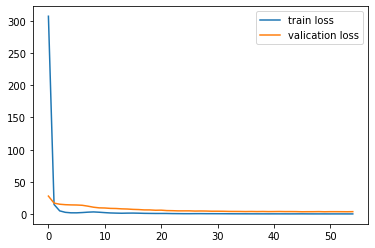

Evaluation:
8000/8000 [==============================] - 0s 48us/sample - loss: 1.2156 - mean_squared_error: 1.2156
training MSE: [1.2155658900737762, 1.2155659]
2000/2000 [==============================] - 0s 47us/sample - loss: 3.9125 - mean_squared_error: 3.9125
test MSE: [3.9124514198303224, 3.912451]


In [235]:
# Input: X (vector length=2000), y(vector length=1000)
X_train, X_test, y_train, y_test = split_data(X, y)
print("X_train.shape = ", X_train.shape)
print("X_test.shape = ", X_test.shape)

print("\ny_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)

keras_model = create_keras_model(2000, 1)
train_test_model(keras_model, pair_tr=X_train, affinity_tr=y_train, pair_ts=X_test, affinity_ts=y_test)#used early stopping

X_train.shape =  (8000, 3000)
X_test.shape =  (2000, 3000)

y_train.shape =  (8000,)
y_test.shape =  (2000,)
Epoch 00011: early stopping


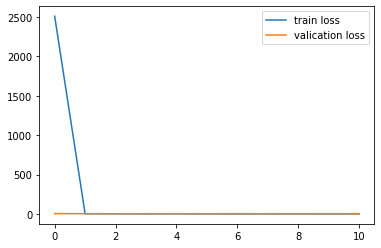

Evaluation:
8000/8000 [==============================] - 0s 62us/sample - loss: 1.5103 - mean_squared_error: 1.5103
training MSE: [1.5102616585493087, 1.5102613]
2000/2000 [==============================] - 0s 60us/sample - loss: 3.8789 - mean_squared_error: 3.8789
test MSE: [3.878934293746948, 3.8789349]


In [236]:
# Input: X with contact map (vector length=3000), y(vector length=1000)
X_train, X_test, y_train, y_test = split_data(X_cm, y)
print("X_train.shape = ", X_train.shape)
print("X_test.shape = ", X_test.shape)

print("\ny_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)

keras_model = create_keras_model(3000, 1)
train_test_model(keras_model, pair_tr=X_train, affinity_tr=y_train, pair_ts=X_test, affinity_ts=y_test)#used early stopping

X_train.shape =  (8000, 3000)
X_test.shape =  (2000, 3000)

y_train.shape =  (8000,)
y_test.shape =  (2000,)
Epoch 00008: early stopping


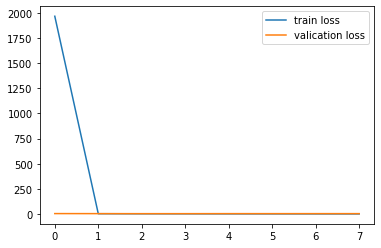

Evaluation:
8000/8000 [==============================] - 0s 61us/sample - loss: 1.7633 - mean_squared_error: 1.7633
training MSE: [1.7632738482952117, 1.763274]
2000/2000 [==============================] - 0s 62us/sample - loss: 4.2293 - mean_squared_error: 4.2293
test MSE: [4.229318906784058, 4.2293196]


In [237]:
# Input: X with center distances (vector length=3000), y(vector length=1000)
X_train, X_test, y_train, y_test = split_data(X_cd, y)
print("X_train.shape = ", X_train.shape)
print("X_test.shape = ", X_test.shape)

print("\ny_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)

keras_model = create_keras_model(3000, 1)
train_test_model(keras_model, pair_tr=X_train, affinity_tr=y_train, pair_ts=X_test, affinity_ts=y_test)#used early stopping

Notes: it seems adding 3D info to the representation of protein does not make it better.

* X

 **Training: MSE=0.?? (epoch=??); Test: MSE=0.??**

* X contact map

 **Training: MSE=0.?? (epoch=??); Test: MSE=0.??**

* X center distances

 **Training: MSE=0.?? (epoch=??); Test: MSE=0.??**


## 4. Use  your model on COVID-19 protease

Now, use your trained model to identify drugs that could be used as COVID-19 protease inhibitors from these 2111 drugs in the dataset. The sequence of the protease is provided in `6Y84_A.fasta.txt`. You might want to first predict a binding affinity of Ritonavior, a well known HIV drug that binds to HIV protease, to get the sense of a good binding score for this task. SMILES of Ritonavior is provided below.  

In [205]:
ritonavior_smile = 'CC(C)C1=NC(=CS1)CN(C)C(=O)NC(C(C)C)C(=O)NC(CC2=CC=CC=C2)CC(C(CC3=CC=CC=C3)NC(=O)OCC4=CN=CS4)O'
molecule = MolFromSmiles(ritonavior_smile)
ECFP2 = Chem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=NBITS).ToBitString()
ritonavior_ECFP = np.array(list(map(int, ECFP2)))*200
print("ritonavior_ECFP.shape = ", ritonavior_ECFP.shape)

ritonavior_ECFP.shape =  (1000,)


In [206]:
HIV_seq = 'PQVTLWQRPIVTIKIGGQLKEALLDTGADDTVLEEMSLPGKWKPKMIGGIGGFIKVRQYDQVSIEICGHKAIGTVLIGPTPVNIIGRNLLTQLGCTLNF'
HIV_amino = seq_to_cat(HIV_seq)
print("HIV_amino.shape = ", HIV_amino.shape)


# def HIV_binding(HIVName):
HIVName = '1dmp' #HIV protease = '1dmp', HIVName = '1tiv'
HIV_cm_uncut = get_protein_contact_map(HIVName, shrinking_ratio=20)
print(len(HIV_cm_uncut))

HIV_cm =  get_protein_cut_contact_map(HIVName, shrinking_ratio=20)
print("HIV_cm.shape = ", HIV_cm.shape)
HIV_cd =  get_protein_cut_center_distances(HIVName)
print("HIV_cd.shape = ", HIV_cd.shape)

HIV_vec_cm = np.concatenate((HIV_amino, HIV_cm))
HIV_vec_cd = np.concatenate((HIV_amino, HIV_cd))
print("\nHIV_vec_cm.shape = ", HIV_vec_cm.shape)
print("HIV_vec_cd.shape = ", HIV_vec_cd.shape)

HIV_amino.shape =  (1000,)
45
HIV_cm.shape =  (1000,)
HIV_cd.shape =  (1000,)

HIV_vec_cm.shape =  (2000,)
HIV_vec_cd.shape =  (2000,)


In [207]:
print(X_cm[10])

[ 11.  16.  15. ... 200.   0.   0.]


In [208]:
all_ligandECFP = X[:, 1000:]
print("all_ligandECFP.shape = ", all_ligandECFP.shape)


def HIV_binding(keras_model, HIV_vec, isLogreg=False):
  HIV_pair = np.concatenate((HIV_vec, ritonavior_ECFP))
  HIV_Ritonavior_score = keras_model.predict(HIV_pair.reshape(1,len(HIV_pair)))[0]
  if not isLogreg:
    HIV_Ritonavior_score = HIV_Ritonavior_score[0]
  print("HIV-Ritonavior_ binding scores:")
  print("HIV_Ritonavior_score = ", HIV_Ritonavior_score)


  print("HIV-AnotherDrug binding scores:")
  HIV_affinities = []
  for i,ligandECFP in enumerate(all_ligandECFP):
    pair = np.concatenate((HIV_vec, ligandECFP))
    aff =  keras_model.predict(pair.reshape(1,len(pair)))[0]
    if not isLogreg:
      aff = aff[0]
    HIV_affinities.append(aff)

  HIV_affinities = np.array(HIV_affinities)
  print("Min affinitiy = ", np.min(HIV_affinities), ".  Max affinitiy = ", np.max(HIV_affinities))
  plt.hist(HIV_affinities, bins=100);
  plt.title("HIV-AnotherLigand Affinities: ")

  print("\nHow many drugs have better bindings with HIV, compared to Ritonavior?")
  print(len(HIV_affinities[HIV_affinities > HIV_Ritonavior_score]) / len(HIV_affinities))
  print("How many drugs have equal bindings with HIV, compared to Ritonavior?")
  print(len(HIV_affinities[HIV_affinities == HIV_Ritonavior_score]) / len(HIV_affinities))

all_ligandECFP.shape =  (10000, 1000)


X_train.shape =  (8000, 2000)
X_test.shape =  (2000, 2000)

y_train.shape =  (8000,)
y_test.shape =  (2000,)
Train on 6400 samples, validate on 1600 samples
Epoch 1/500
6400/6400 [==============================] - 1s 115us/sample - loss: 271.0400 - mean_squared_error: 271.0399 - val_loss: 26.1791 - val_mean_squared_error: 26.1791
Epoch 2/500
6400/6400 [==============================] - 1s 82us/sample - loss: 12.8255 - mean_squared_error: 12.8255 - val_loss: 14.2183 - val_mean_squared_error: 14.2183
Epoch 3/500
6400/6400 [==============================] - 1s 82us/sample - loss: 4.4523 - mean_squared_error: 4.4523 - val_loss: 12.6231 - val_mean_squared_error: 12.6231
Epoch 4/500
6400/6400 [==============================] - 1s 79us/sample - loss: 2.5941 - mean_squared_error: 2.5941 - val_loss: 12.1776 - val_mean_squared_error: 12.1776
Epoch 5/500
6400/6400 [==============================] - 1s 83us/sample - loss: 1.9361 - mean_squared_error: 1.9361 - val_loss: 12.1445 - val_mean_squared_e

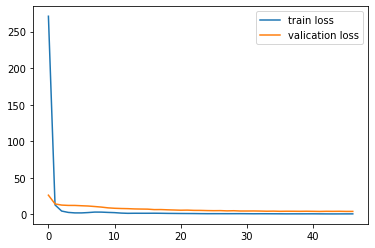

Evaluation:
8000/8000 [==============================] - 0s 47us/sample - loss: 1.2363 - mean_squared_error: 1.2363
training MSE: [1.2362691244482995, 1.236269]
2000/2000 [==============================] - 0s 47us/sample - loss: 4.0593 - mean_squared_error: 4.0593
test MSE: [4.059274520874023, 4.059274]


In [209]:
#Get model
# Input: X with center distances (vector length=2000), y(vector length=1000)
X_train, X_test, y_train, y_test = split_data(X, y)
print("X_train.shape = ", X_train.shape)
print("X_test.shape = ", X_test.shape)

print("\ny_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)


model = create_keras_model(2000, 1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer='adam',
              loss= 'mean_squared_error', 
              metrics=['mse']) 
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=[es])

# plot training history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valication loss')
plt.legend()
plt.show()

print("Evaluation:")
print('training MSE:', model.evaluate(X_train, y_train))
print('test MSE:', model.evaluate(X_test, y_test))



HIV-Ritonavior_ binding scores:
HIV_Ritonavior_score =  815
HIV-AnotherDrug binding scores:
Min affinitiy =  49 .  Max affinitiy =  885

How many drugs have better bindings with HIV, compared to Ritonavior?
0.139
How many drugs have equal bindings with HIV, compared to Ritonavior?
0.0089


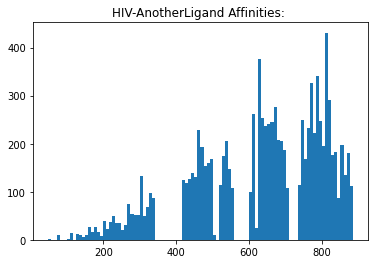

In [229]:
HIV_vec = HIV_amino
HIV_binding(clf, HIV_vec, True)

HIV-Ritonavior_ binding scores:
HIV_Ritonavior_score =  4.6524706
HIV-AnotherDrug binding scores:
Min affinitiy =  -3.8969522 .  Max affinitiy =  12.994567

How many drugs have better bindings with HIV, compared to Ritonavior?
0.6835
How many drugs have equal bindings with HIV, compared to Ritonavior?
0.0002


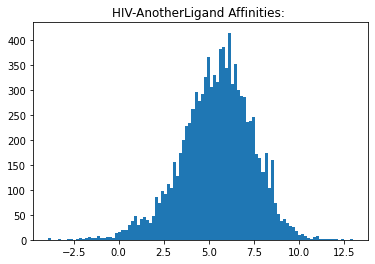

In [210]:
HIV_vec = HIV_amino
HIV_binding(model, HIV_vec)

X_train.shape =  (8000, 3000)
X_test.shape =  (2000, 3000)

y_train.shape =  (8000,)
y_test.shape =  (2000,)
Train on 6400 samples, validate on 1600 samples
Epoch 1/500
6400/6400 [==============================] - 1s 149us/sample - loss: 1965.6965 - mean_squared_error: 1965.6965 - val_loss: 5.0006 - val_mean_squared_error: 5.0006
Epoch 2/500
6400/6400 [==============================] - 1s 117us/sample - loss: 4.3632 - mean_squared_error: 4.3632 - val_loss: 8.6549 - val_mean_squared_error: 8.6549
Epoch 3/500
6400/6400 [==============================] - 1s 114us/sample - loss: 3.1874 - mean_squared_error: 3.1874 - val_loss: 4.9531 - val_mean_squared_error: 4.9531
Epoch 4/500
6400/6400 [==============================] - 1s 116us/sample - loss: 3.1905 - mean_squared_error: 3.1905 - val_loss: 4.7761 - val_mean_squared_error: 4.7761
Epoch 5/500
6400/6400 [==============================] - 1s 110us/sample - loss: 2.8112 - mean_squared_error: 2.8112 - val_loss: 6.6586 - val_mean_squared_error:

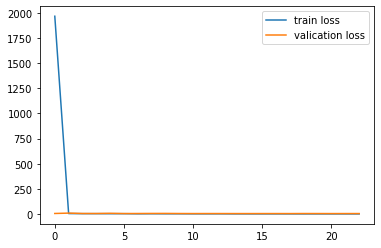

Evaluation:
8000/8000 [==============================] - 0s 60us/sample - loss: 1.3958 - mean_squared_error: 1.3958
training MSE: [1.3958185811042785, 1.395819]
2000/2000 [==============================] - 0s 58us/sample - loss: 4.2886 - mean_squared_error: 4.2886
test MSE: [4.288573631286621, 4.288574]


In [211]:
#Get model_cm
# Input: X with center distances (vector length=3000), y(vector length=1000)
X_train, X_test, y_train, y_test = split_data(X_cm, y)
print("X_train.shape = ", X_train.shape)
print("X_test.shape = ", X_test.shape)

print("\ny_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)



model_cm = create_keras_model(3000, 1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model_cm.compile(optimizer='adam',
              loss= 'mean_squared_error', 
              metrics=['mse']) 
history = model_cm.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=[es])

# plot training history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valication loss')
plt.legend()
plt.show()

print("Evaluation:")
print('training MSE:', model_cm.evaluate(X_train, y_train))
print('test MSE:', model_cm.evaluate(X_test, y_test))



HIV-Ritonavior_ binding scores:
HIV_Ritonavior_score =  8.416308
HIV-AnotherDrug binding scores:
Min affinitiy =  -0.05656214 .  Max affinitiy =  10.541729

How many drugs have better bindings with HIV, compared to Ritonavior?
0.0113
How many drugs have equal bindings with HIV, compared to Ritonavior?
0.0002


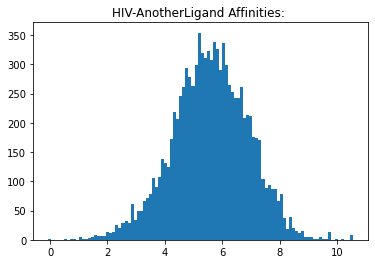

In [212]:
HIV_vec = np.concatenate((HIV_amino, HIV_cm))
HIV_binding(model_cm, HIV_vec)

X_train.shape =  (8000, 3000)
X_test.shape =  (2000, 3000)

y_train.shape =  (8000,)
y_test.shape =  (2000,)
Train on 6400 samples, validate on 1600 samples
Epoch 1/500
6400/6400 [==============================] - 1s 153us/sample - loss: 3003.6383 - mean_squared_error: 3003.6360 - val_loss: 5.1998 - val_mean_squared_error: 5.1998
Epoch 2/500
6400/6400 [==============================] - 1s 112us/sample - loss: 4.3251 - mean_squared_error: 4.3251 - val_loss: 4.5362 - val_mean_squared_error: 4.5362
Epoch 3/500
6400/6400 [==============================] - 1s 114us/sample - loss: 3.8032 - mean_squared_error: 3.8032 - val_loss: 4.7709 - val_mean_squared_error: 4.7709
Epoch 4/500
6400/6400 [==============================] - 1s 113us/sample - loss: 3.2837 - mean_squared_error: 3.2837 - val_loss: 4.7461 - val_mean_squared_error: 4.7461
Epoch 5/500
6400/6400 [==============================] - 1s 114us/sample - loss: 2.8613 - mean_squared_error: 2.8613 - val_loss: 4.9786 - val_mean_squared_error:

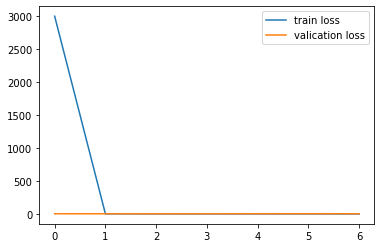

Evaluation:
8000/8000 [==============================] - 0s 60us/sample - loss: 2.5136 - mean_squared_error: 2.5136
training MSE: [2.5136020851135252, 2.513602]
2000/2000 [==============================] - 0s 65us/sample - loss: 4.6738 - mean_squared_error: 4.6738
test MSE: [4.673771312713623, 4.6737714]


In [213]:
#Get model_cd
# Input: X with center distances (vector length=3000), y(vector length=1000)
X_train, X_test, y_train, y_test = split_data(X_cd, y)
print("X_train.shape = ", X_train.shape)
print("X_test.shape = ", X_test.shape)

print("\ny_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)



model_cd = create_keras_model(3000, 1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model_cd.compile(optimizer='adam',
              loss= 'mean_squared_error', 
              metrics=['mse']) 
history = model_cd.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=[es])

# plot training history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valication loss')
plt.legend()
plt.show()

print("Evaluation:")
print('training MSE:', model_cd.evaluate(X_train, y_train))
print('test MSE:', model_cd.evaluate(X_test, y_test))



HIV-Ritonavior_ binding scores:
HIV_Ritonavior_score =  6.072077
HIV-AnotherDrug binding scores:
Min affinitiy =  -0.13931721 .  Max affinitiy =  15.277287

How many drugs have better bindings with HIV, compared to Ritonavior?
0.3157
How many drugs have equal bindings with HIV, compared to Ritonavior?
0.0002


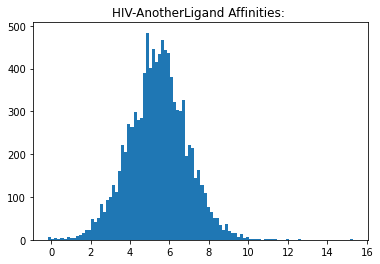

In [214]:
HIV_vec = np.concatenate((HIV_amino, HIV_cd))
HIV_binding(model_cd, HIV_vec)

TODO: edit below:
* When using 1000-vector for drugs:

   It seems almost 70% out of the 2111 drugs bind better with HIV, compared to Ritonavior. Thus our model might not be good enough?

* When using 1000-vector for drugs:

  Indeed Ritonavior has the highest binding score, but 94% of the 2111 drugs have the same binding score...


In [215]:
covid_amino = get_protein_amino_acids('6y84')
print("covid_amino.shape = ", covid_amino.shape)


# def covid_binding(covidName):
covidName = '6y84' 
covid_cm_uncut = get_protein_contact_map(covidName, shrinking_ratio=20)
print(len(covid_cm_uncut))

covid_cm =  get_protein_cut_contact_map(covidName, shrinking_ratio=20)
print("covid_cm.shape = ", covid_cm.shape)
covid_cd =  get_protein_cut_center_distances(covidName)
print("covid_cd.shape = ", covid_cd.shape)

covid_vec_cm = np.concatenate((covid_amino, covid_cm))
covid_vec_cd = np.concatenate((covid_amino, covid_cd))
print("\ncovid_vec_cm.shape = ", covid_vec_cm.shape)
print("covid_vec_cd.shape = ", covid_vec_cd.shape)

covid_amino.shape =  (1000,)
120
covid_cm.shape =  (1000,)
covid_cd.shape =  (1000,)

covid_vec_cm.shape =  (2000,)
covid_vec_cd.shape =  (2000,)


In [251]:
def covid_binding(keras_model, covid_vec, isLogreg=False):
  # covid_pair = np.concatenate((covid_vec, ritonavior_ECFP))
  # covid_Ritonavior_score = keras_model.predict(covid_pair.reshape(1,len(covid_pair)))[0][0]
  # print("covidcm-Ritonavior_ binding scores:")
  # print("covid_Ritonavior_score = ", covid_Ritonavior_score)


  print("covid-Drug binding scores:")
  covid_affinities = []
  for i,ligandECFP in enumerate(all_ligandECFP):
    pair = np.concatenate((covid_vec, ligandECFP))
    aff =  keras_model.predict(pair.reshape(1,len(pair)))[0]
    if not isLogreg:
      aff = aff[0]
    covid_affinities.append(aff)

  covid_affinities = np.array(covid_affinities)
  print("Min affinitiy = ", np.min(covid_affinities), ".  Max affinitiy = ", np.max(covid_affinities))
  plt.hist(covid_affinities, bins=100);
  plt.title("covid Affinities: ")
  return covid_affinities
  # print("\nHow many drugs have better bindings with covid, compared to Ritonavior?")
  # print(len(covid_affinities[covid_affinities > covid_Ritonavior_score]) / len(covid_affinities))
  # print("How many drugs have equal bindings with covid, compared to Ritonavior?")
  # print(len(covid_affinities[covid_affinities == covid_Ritonavior_score]) / len(covid_affinities))

In [217]:
def get_top_drugs(covid_affinities):
  print("Below are the Top 10 drug candidates for COVID-19:")
  print("Affinitiy score       Drug smiles: ")

  for idx in np.argsort(covid_affinities)[-10:]:
    drug_smiles = pdb_ligandName[idx]
    aff_score = covid_affinities[idx]
    print(aff_score, "         ",  drug_smiles)

covid-Drug binding scores:
Min affinitiy =  -1.1975429 .  Max affinitiy =  13.196471


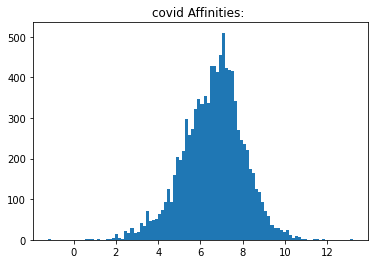

In [218]:
covid_affinities=covid_binding(model, covid_amino)

In [219]:
get_top_drugs(covid_affinities)

Below are the Top 10 drug candidates for COVID-19:
Affinitiy score       Drug smiles: 
10.841564           (759)
10.849892           (40Z)
10.870573           (D5I)
10.973335           (038)
10.986149           (DQG)
11.375539           (A97)
11.411058           (2H7)
11.5765           (FVQ)
11.846134           (SG2)
13.196471           (2MQ)


covid-Drug binding scores:
Min affinitiy =  1.9734732 .  Max affinitiy =  11.109931


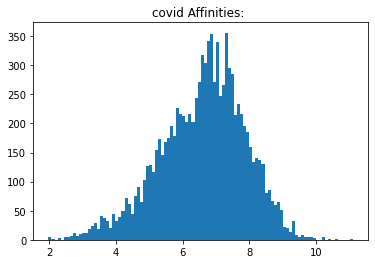

In [220]:
covid_vec = np.concatenate((covid_amino, covid_cm))
covid_affinities_cm=covid_binding(model_cm, covid_vec)

In [221]:
get_top_drugs(covid_affinities_cm)

Below are the Top 10 drug candidates for COVID-19:
Affinitiy score       Drug smiles: 
9.939889           (STL)
9.96963           (3EJ)
9.976301           (CKK)
10.200956           (7Q1)
10.200956           (WWO)
10.200956           (ADP)
10.237065           (E6T)
10.44796           (444)
10.574654           (TCB)
11.109931           (ZAR)


covid-Drug binding scores:
Min affinitiy =  0.0956367 .  Max affinitiy =  15.808147


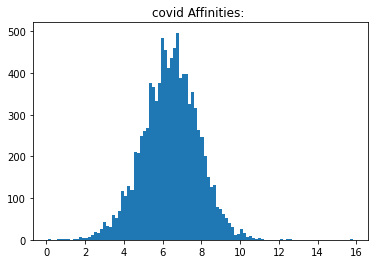

In [222]:
covid_vec = np.concatenate((covid_amino, covid_cd))
covid_affinities_cd=covid_binding(model_cd, covid_vec)

In [223]:
get_top_drugs(covid_affinities_cd)

Below are the Top 10 drug candidates for COVID-19:
Affinitiy score       Drug smiles: 
11.061966           (NHI)
11.072758           (GXE)
11.171318           (6DP)
12.115985           (XPF)
12.115985           (57R)
12.490885           (ZD6)
12.602945           (LZ8)
12.602945           (AD6)
15.808147           (P17)
15.808147           (RBF)


Logistic Regression:

In [238]:
X_train, X_test, y_train, y_test = split_data(X, y)

y_train_int = []
for y_float in y_train:
  y_train_int.append(round(y_float*100))

y_train_int[:10]
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train_int)

y_pred=lr.predict(X_test)/100
print(y_pred[:10])
print(mean_squared_error(y_test, y_pred))

[7.46 7.   5.3  6.42 8.04 8.4  2.98 6.6  3.   7.96]
5.20442475


In [239]:
X_train, X_test, y_train, y_test = split_data(X_cm, y)

y_train_int = []
for y_float in y_train:
  y_train_int.append(round(y_float*100))

y_train_int[:10]

lr_cm = LogisticRegression()
lr_cm.fit(X_train, y_train_int)
y_pred=lr_cm.predict(X_test)/100
print(y_pred[:10])
mean_squared_error(y_test, y_pred)

[7.46 7.   5.3  8.22 8.04 6.88 2.98 6.52 6.77 7.96]


4.8767024

In [240]:
X_train, X_test, y_train, y_test = split_data(X_cd, y)

y_train_int = []
for y_float in y_train:
  y_train_int.append(round(y_float*100))

y_train_int[:10]

lr_cd = LogisticRegression()
lr_cd.fit(X_train, y_train_int)
y_pred=lr_cd.predict(X_test)/100
print(y_pred[:10])
mean_squared_error(y_test, y_pred)

[7.46 7.   5.3  6.42 8.04 6.6  2.98 6.52 3.   7.96]


4.859327649999999

HIV-Ritonavior_ binding scores:
HIV_Ritonavior_score =  815
HIV-AnotherDrug binding scores:
Min affinitiy =  49 .  Max affinitiy =  885

How many drugs have better bindings with HIV, compared to Ritonavior?
0.139
How many drugs have equal bindings with HIV, compared to Ritonavior?
0.0089


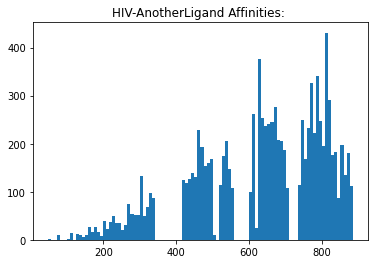

In [242]:
HIV_vec = HIV_amino
HIV_binding(clf, HIV_vec, True)

HIV-Ritonavior_ binding scores:
HIV_Ritonavior_score =  815
HIV-AnotherDrug binding scores:
Min affinitiy =  49 .  Max affinitiy =  885

How many drugs have better bindings with HIV, compared to Ritonavior?
0.1233
How many drugs have equal bindings with HIV, compared to Ritonavior?
0.0103


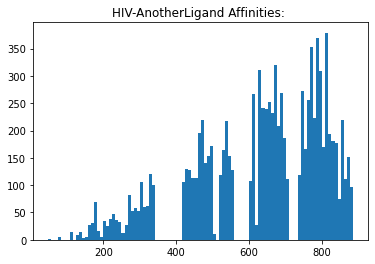

In [243]:
HIV_vec = np.concatenate((HIV_amino, HIV_cm))
HIV_binding(lr_cm, HIV_vec, True)

HIV-Ritonavior_ binding scores:
HIV_Ritonavior_score =  815
HIV-AnotherDrug binding scores:
Min affinitiy =  49 .  Max affinitiy =  885

How many drugs have better bindings with HIV, compared to Ritonavior?
0.1303
How many drugs have equal bindings with HIV, compared to Ritonavior?
0.0148


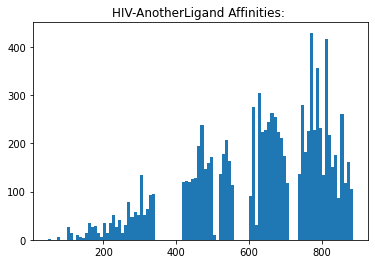

In [244]:
HIV_vec = np.concatenate((HIV_amino, HIV_cd))
HIV_binding(lr_cd, HIV_vec, True)

covid-Drug binding scores:
Min affinitiy =  49 .  Max affinitiy =  885
Below are the Top 10 drug candidates for COVID-19:
Affinitiy score       Drug smiles: 
885           (AR6)
885           (8W6)
885           (FGV)
885           (GIM)
885           (RXM)
885           (N93)
885           (SA8)
885           (4TU)
885           (15U)
885           (PD2)


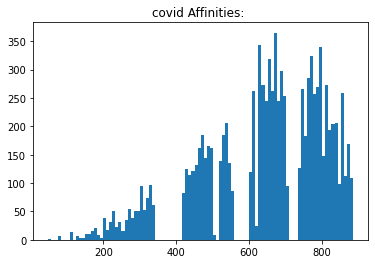

In [252]:
covid_affinities=covid_binding(lr, covid_amino, True)
get_top_drugs(covid_affinities)

covid-Drug binding scores:
Min affinitiy =  49 .  Max affinitiy =  885
Below are the Top 10 drug candidates for COVID-19:
Affinitiy score       Drug smiles: 
885           (0DU)
885           (F79)
885           (XNZ)
885           (PD2)
885           (AR6)
885           (40F)
885           (GIM)
885           (CKH)
885           (2TA)
885           (RET)


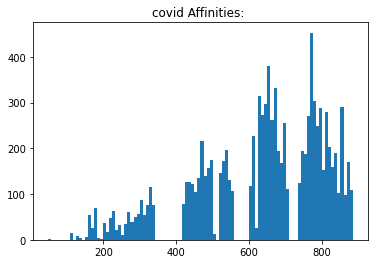

In [253]:
covid_vec = np.concatenate((covid_amino, covid_cm))
covid_affinities_cm=covid_binding(lr_cm, covid_vec, True)
get_top_drugs(covid_affinities_cm)

covid-Drug binding scores:
Min affinitiy =  49 .  Max affinitiy =  885
Below are the Top 10 drug candidates for COVID-19:
Affinitiy score       Drug smiles: 
885           (17K)
885           (RET)
885           (RXM)
885           (F79)
885           (56H)
885           (GIM)
885           (PD2)
885           (AR6)
885           (3XL)
885           (2SE)


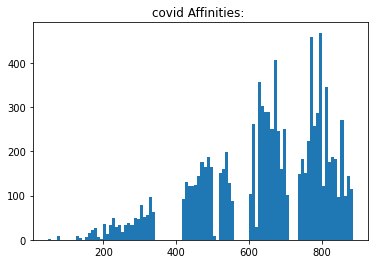

In [254]:
covid_vec = np.concatenate((covid_amino, covid_cd))
covid_affinities_cd=covid_binding(lr_cd, covid_vec, True)
get_top_drugs(covid_affinities_cd)